In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    1: load_data('../stats/fpm_5_2D_x1.json'),
    2: load_data('../stats/fpm_5_2D_x2.json'),
    3: load_data('../stats/fpm_5_2D_x3.json'),
    4: load_data('../stats/fpm_5_2D_x4.json'),
    5: load_data('../stats/fpm_5_2D_x5.json'),
    6: load_data('../stats/fpm_5_2D_x6.json'),
}

# data = {
#     1: load_data('../stats/fpm_5_2D_direct_x1.json'),
#     2: load_data('../stats/fpm_5_2D_direct_x2.json'),
#     3: load_data('../stats/fpm_5_2D_direct_x3.json'),
#     4: load_data('../stats/fpm_5_2D_direct_x4.json'),
#     5: load_data('../stats/fpm_5_2D_direct_x5.json'),
#     6: load_data('../stats/fpm_5_2D_direct_x6.json'),
# }

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
shape = [3, 2]
figsize = (12, 6)

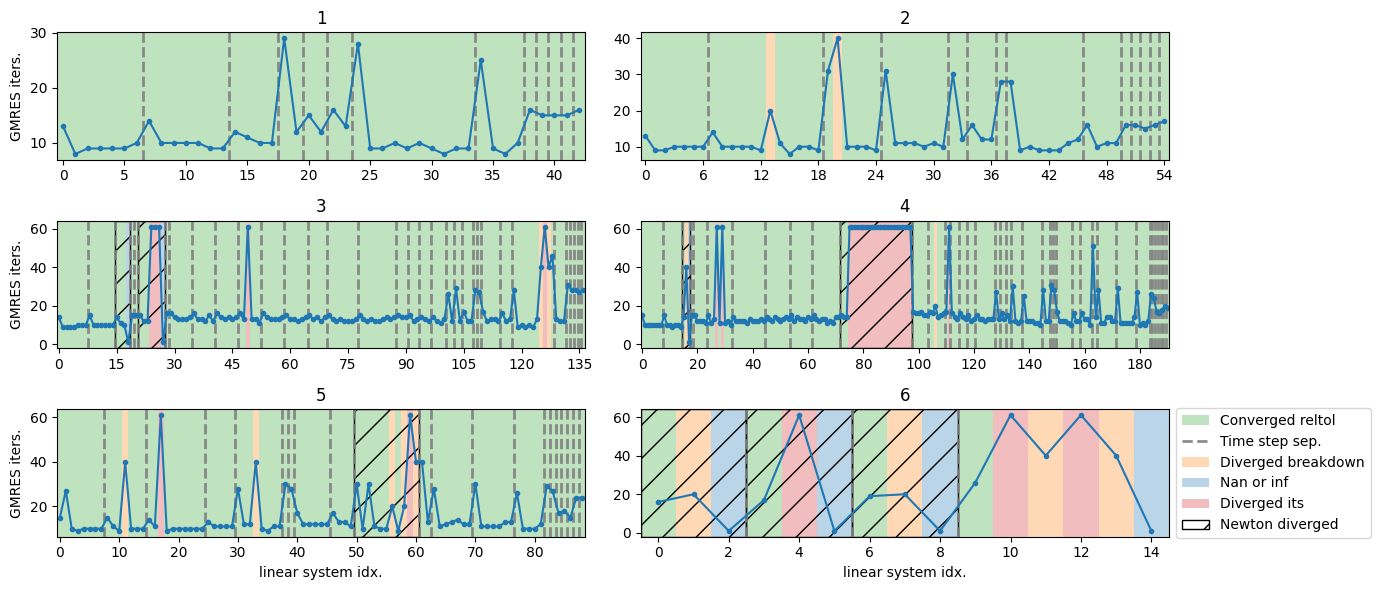

In [3]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

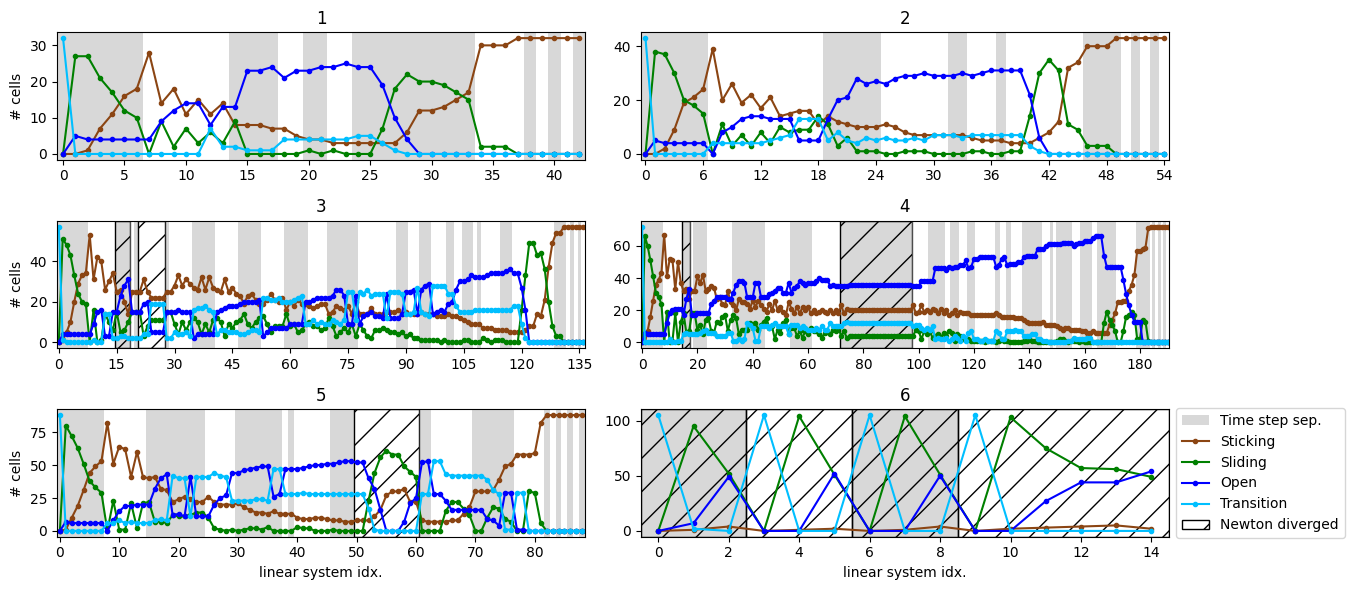

In [4]:
plot_grid(data, plot_sticking_sliding_open_transition, shape=shape, figsize=figsize, ylabel='# cells')

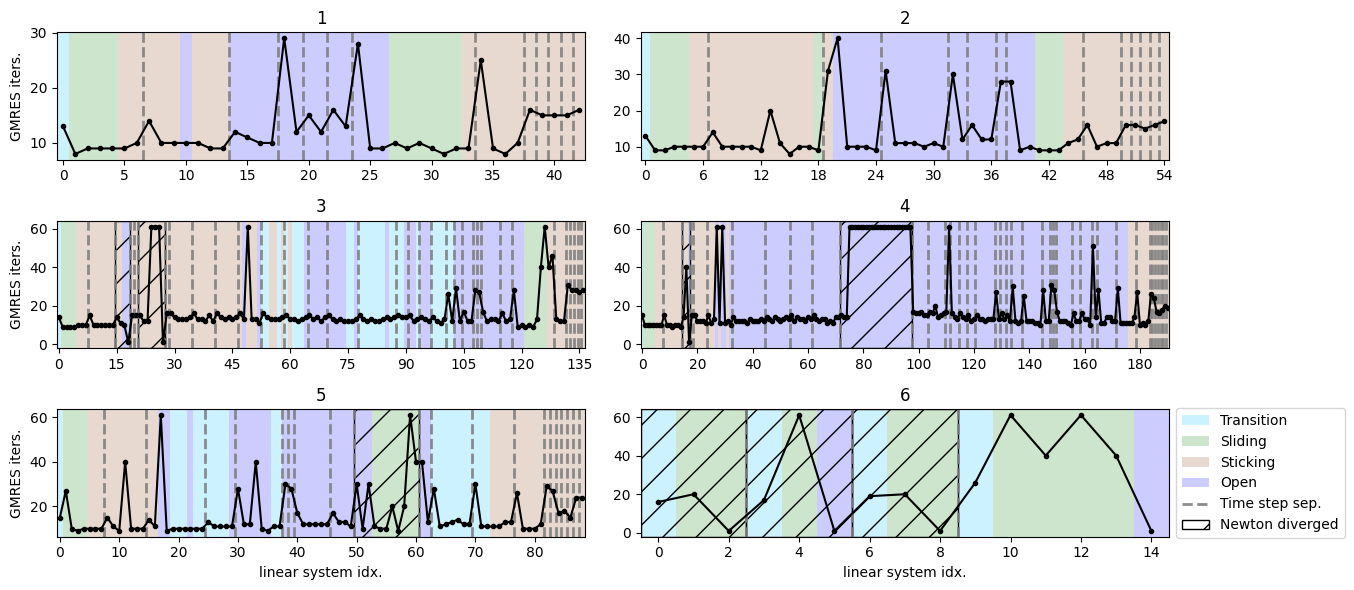

In [5]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=15)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

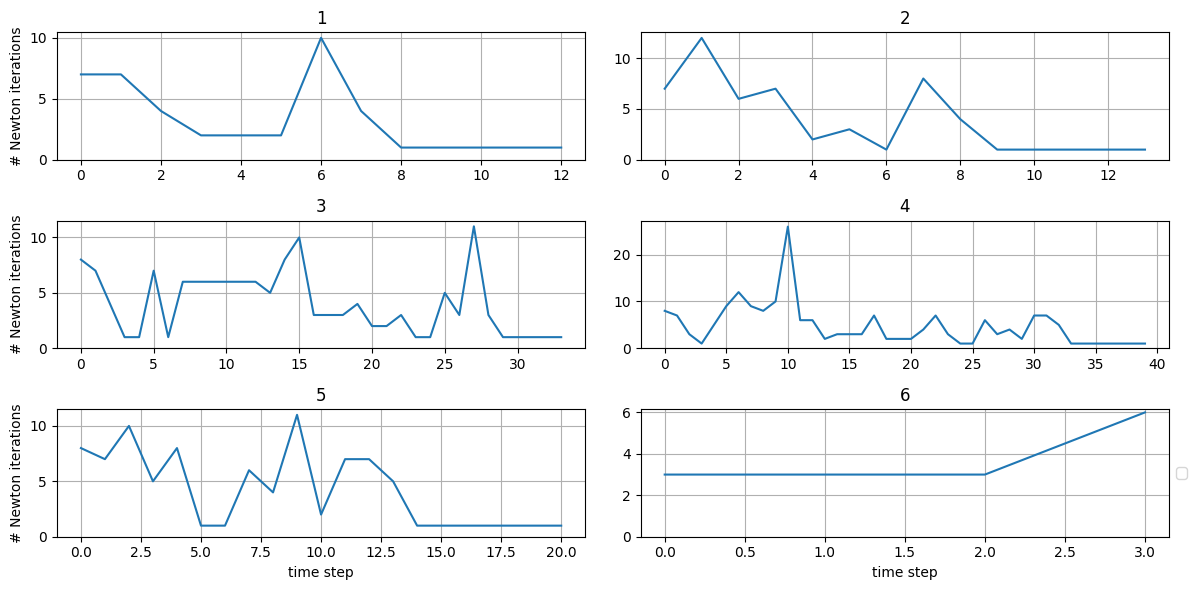

In [6]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

# Testing bad matrix

In [7]:
assert False

AssertionError: 

In [ ]:
from fpm_5_2D import make_model
cell_size_multiplier = 3
model = make_model(cell_size_multiplier=cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 57


In [ ]:
mat_idx = 18
entry = data[cell_size_multiplier]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

1


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

14
10
31
2


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Divergence [1]
Divergence [0, 2]
Divergence [1]
Divergence [1, 0, 2]
Divergence [5]
Divergence [5, 1, 0, 2]
Divergence [3]
Divergence [3, 5, 1, 0, 2]
Divergence [4]
Solve  took: 0.02
True residual permuted: 1.0
True residual: 1.0
PETSc Converged Reason: -9


{'mat_Q': BlockMatrixStorage of shape (4485, 4485) with 158867 elements with 6x6 active groups}

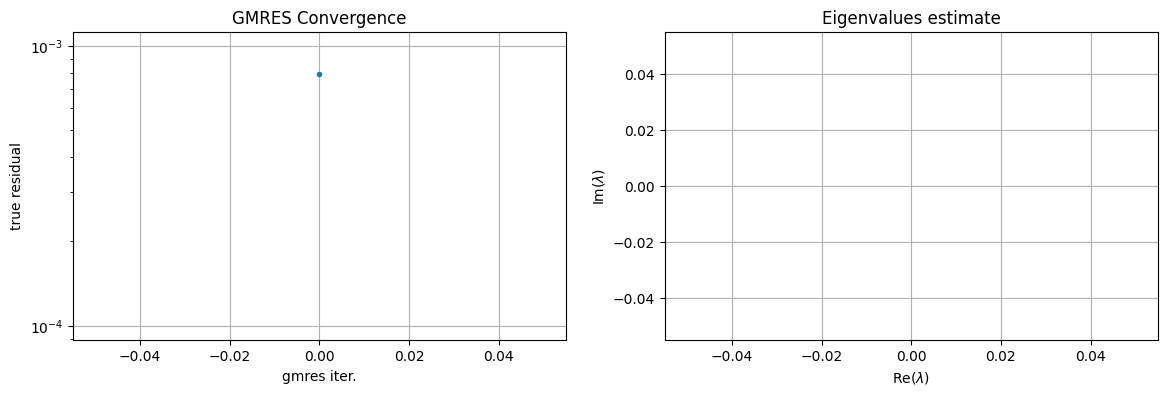

In [ ]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

Solve  took: 0.11
True residual permuted: 0.011934179348181322
True residual: 0.011934179348529177
PETSc Converged Reason: -5
lambda min: 0.31653615984067074


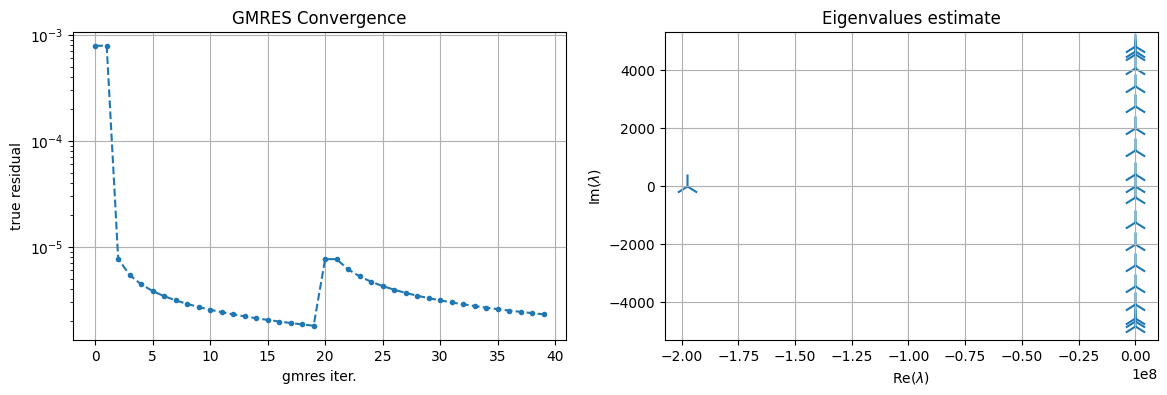

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    groups=[4],
    complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor_type="physical",
            invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            # complement=SolveSchema(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            # ),
        # ),
    ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

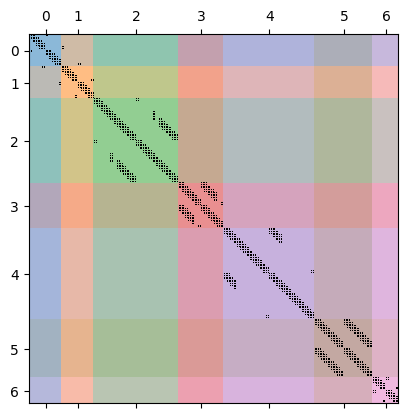

In [ ]:
J = model.bmat.copy()
J.mat = J.mat @ model.Qright.mat
# J.plot_max()
J.build_schur_complement(keep=[5], elim=[4]).color_spy(groups=False, marker=',')